In [37]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pickle as pkl

from finite import curves_one_stage
from finite import greedy, dp, beta, get_data
from tqdm import tqdm_notebook


import matplotlib
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
matplotlib.style.use('classic')
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams

# Read data

In [11]:
data = pd.read_csv("./data/jee/jee2009.csv") # if missing, download here https://github.com/AnayMehrotra/Ranking-with-Implicit-Bias
data = data.dropna(subset=['mark', 'GENDER'])

In [12]:
data.head()

REGST_NO             NAME category sub_category GENDER PIN_RES  \
0   2045263        VIBHU PAL       GE           NN      M  208011   
1   2023172  NITESH BHARDWAJ       GE           NN      M  110046   
2   2040146          MANJEET       GE           NN      M  110085   
3   2032358    SHIKHAR DATTA       GE           NN      M  110075   
4   2078152            RAJAT       GE           NN      M  121001   

            PARENT_NAM  math  phys  chem  mark  
0      SAROJ KUMAR PAL    30    33    26    89  
1  OM PRAKASH BHARDWAJ    38    26    33    97  
2       DEVENDER SINGH    29    10    30    69  
3    SUNIL KUMAR DATTA     6    -8    12    10  
4      RAJESHWAR SINGH    11    -4    -9    -2

In [13]:
data.shape

(384970, 11)

In [14]:
q = np.copy(data.mark.to_numpy()).astype('float')
g = np.copy(data.GENDER.to_numpy())
g[g == 'M'] = 0
g[g == 'F'] = 1

In [15]:
plt.figure(figsize=(3,3))
x = np.arange(-200, 300, 0.1)
_=plt.hist(q[g==0], bins=50, color='b', alpha=0.3, density=True, label='$W_\mathrm{men}$',histtype='stepfilled')
_=plt.hist(q[g==1], bins=50, color='r', alpha=0.3, density=True, label='$W_\mathrm{women}$', histtype='stepfilled')

mu = np.mean(q[(q > -60)& (q < 100)])
std = np.std(q[(q > -60)& (q < 100)])
# plt.plot(x, st.norm(mu, std).pdf(x), ls='--', lw=1.5, color='k')

plt.xlim(-100, 300)
plt.legend(loc='upper right')
plt.xlabel("$w$", fontsize=14)
plt.ylabel("$p_{W}$", fontsize=14)
plt.yticks(fontsize=7)
plt.xticks(fontsize=10)

plt.savefig("../fig/jee-q.pdf", bbox_inches='tight')

# Add noise

In [16]:
sm = 10
sf = 40
n = len(g)
nf = g.sum()
nm = n - nf
x = np.zeros(n)
x[g==1] = q[g==1] + st.norm(0, sf).rvs(nf)
x[g==0] = q[g==0] + st.norm(0, sm).rvs(nm)

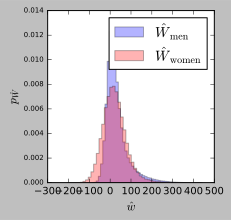

In [17]:
plt.figure(figsize=(3,3))
_=plt.hist(x[g==0], bins=50, color='b', alpha=0.3, density=True, label='$\hat W_\mathrm{men}$', histtype='stepfilled')
_=plt.hist(x[g==1], bins=50, color='r', alpha=0.3, density=True, label='$\hat W_\mathrm{women}$', histtype='stepfilled')
# _=plt.hist(q, bins=50, color='r', alpha=0.3, density=True, label='female')
plt.legend(loc='upper right')
plt.xlabel("$\\hat w$")
# plt.ylabel("$p_{\\hat W}(\\hat w)$", fontsize=14)
plt.ylabel("$p_{\\hat W}$")
plt.yticks(fontsize=7)

plt.xticks(fontsize=10)
plt.savefig("../fig/jee-x.pdf", bbox_inches='tight')

In [18]:
np.std(x[g==0]), np.std(x[g==1])

(52.77431239617423, 55.95199708588223)

In [19]:
np.std(q[g==0]), np.std(q[g==1])

(51.80266380570883, 39.26794876260872)

In [20]:
np.mean(x[g==0]), np.mean(x[g==1])

(30.779659940510346, 21.223619252454043)

In [21]:
np.mean(q[g==0]), np.mean(q[g==1])

(30.792989524015308, 21.235667360346024)

In [24]:
mu = np.array([np.mean(q[g==1]), np.mean(q[g==0])])
mu
eta = np.array([np.std(q[g==1]), np.std(q[g==0])])
eta
pg = np.array([nf/n, nm/n])
pg
sigma = np.array([sm, sm * factors[-1]])

# One-Stage Selection

In [23]:
factors = [1, 4, 7, 10]
a1min = 0.02
a1s = np.arange(a1min, 1.005, 0.005)

In [29]:


res = {'gr': [], 'dp': [], 'opt': []}

sm = 10

for factor in tqdm_notebook(factors):
    x = np.zeros(n)
    x[g==1] = q[g==1] + st.norm(0, sm * factor).rvs(nf)
    x[g==0] = q[g==0] + st.norm(0, sm).rvs(nm)
    data = q, x, g
    sigma = np.array([sm*factor, sm])
    xtilde = []
    r = (g * eta[0] + (1-g)*eta[1])**2 / ((g * eta[0] + (1-g)*eta[1])**2 + (g * sigma[0] + (1-g)*sigma[1])**2)
    mus = (g * mu[0] + (1-g)*mu[1])
    xtilde= x * r + mus * (1 - r)
    new_data = (q, xtilde, g)
    res['gr'].append(curves_one_stage(data, a1s, T=1, alg=greedy))
    res['opt'].append(curves_one_stage(new_data, a1s, T=1, alg=greedy))
    res['dp'].append(curves_one_stage(data, a1s, T=1, alg=dp))

res['gr'] = np.array(res['gr'])
res['dp'] = np.array(res['dp'])
res['opt'] = np.array(res['opt'])

with open("./data/jee/jee-1-stage-{}.pkl".format(a1min), 'wb') as f:
    pkl.dump(res, f)

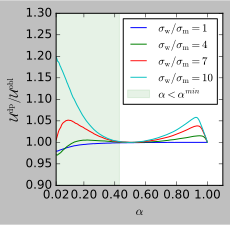

In [30]:
a1min=0.02

with open("./data/jee/jee-1-stage-{}.pkl".format(a1min), 'rb') as f:
    res = pkl.load(f)
             
plt.figure(figsize=(3,3))
ls = ['-', '--', '-.', ':']

for i, factor in enumerate(factors):
    a1 = res['dp'][i, 0, :]

    plt.plot(a1, res['dp'][i,1,:] / res['gr'][i,1,:], '-',\
             label='$\\sigma_\mathrm{w} / \\sigma_\mathrm{m}=$'+'${}$'.format(factor), ls='-')

sigmah = np.sqrt(eta**2  + sigma**2)
aopt = st.norm.cdf((mu[0]-mu[1])/(sigmat[0]-sigmat[1]))
aobl = st.norm.cdf((mu[0]-mu[1])/(sigmah[0]-sigmah[1]))
plt.fill_between(a1s, y1=0.9, y2=1.3, where=a1s < aobl, alpha=0.1, color='g', label='$\\alpha < \\alpha^{min}$')


plt.xlabel("$\\alpha$")
plt.ylabel("$\mathcal{U}^\mathrm{dp}/ \mathcal{U}^\mathrm{obl}$", rotation=90)
plt.legend(loc='upper right', fontsize=11)
plt.xlim(0.02, 1.1)
plt.ylim(0.9, 1.3)
plt.xticks([0.02, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig("../fig/jee-dp-obl.pdf", bbox_inches='tight')

In [31]:
def dU(alpha, mu, sigmat, p):
    ppf = st.norm.ppf(1-alpha)
    return p[0] / alpha * (mu[0] - mu[1] + ppf * (sigmat[0] - sigmat[1]))

def U(alpha, mu, sigmat, p):
    ppf = st.norm.ppf(1-alpha)
    return (mu * p).sum() + st.norm.pdf(ppf)/alpha * np.sum(sigmat * p)
    
def upper_bound(alpha, mu, sigmat, p):
    return 1. - alpha * dU(alpha, mu, sigmat, p) / U(alpha, mu, sigmat, p)

def upper_bound2(alpha, mu, sigmat, p):
    return 1. + (1 - alpha) * dU(alpha, mu, sigmat, p) / U(alpha, mu, sigmat, p)

In [32]:
sigmat = eta / np.sqrt(sigma**2 + eta**2)
bounds = upper_bound(a1s, mu, sigmat, pg)
bounds2 = upper_bound2(a1s, mu, sigmat, pg)

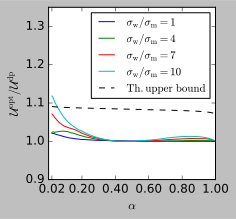

In [34]:
a1min=0.02

with open("./data/jee/jee-1-stage-{}.pkl".format(a1min), 'rb') as f:
    res = pkl.load(f)
             
plt.figure(figsize=(3,3))
ls = ['-', '--', '-.', ':']

for i, factor in enumerate(factors):
    a1 = res['dp'][i, 0, :]

    plt.plot(a1, res['opt'][i,1,:] / res['dp'][i,1,:], '-',\
             label='$\\sigma_\mathrm{w} / \\sigma_\mathrm{m}=$'+'${}$'.format(factor), ls='-')
    plt.axhline(0, ls=':', color='k', alpha=0.2, )
plt.plot(a1s[:], bounds[:], 'k--', label='$\mathrm{Th. upper\ bound}$')

plt.xlabel("$\\alpha$")
plt.ylabel("$\mathcal{U}^\mathrm{opt}/ \mathcal{U}^\mathrm{dp}$", rotation=90)
plt.legend(loc='upper right', fontsize=11)
plt.ylim(0.9, 1.35)
plt.xticks([0.02, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig("../fig/jee-opt-dp.pdf", bbox_inches='tight')